In [33]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import os
from tqdm import tqdm
from icecream import ic
import plotly.express as px

In [2]:
# Step 2: Extract and Visualize Data from alldat.
# Load Data

# Filenames corresponding to the URLs
filenames = [
    'steinmetz_part1.npz',
    'steinmetz_part2.npz',
    'steinmetz_part3.npz'
]

lfp_filename = r"steinmetz_lfp.npz"

file_directory = r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\NEURONS"

save_dir = r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\figures"

# Function to load data from npz files
def load_data(filenames):
    alldat = np.array([])
    for filename in filenames:
        data = np.load(os.path.join(file_directory,filename), allow_pickle=True)['dat']
        alldat = np.hstack((alldat, data))
    return alldat

# Download data if not already present
# download_data(urls, filenames)

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

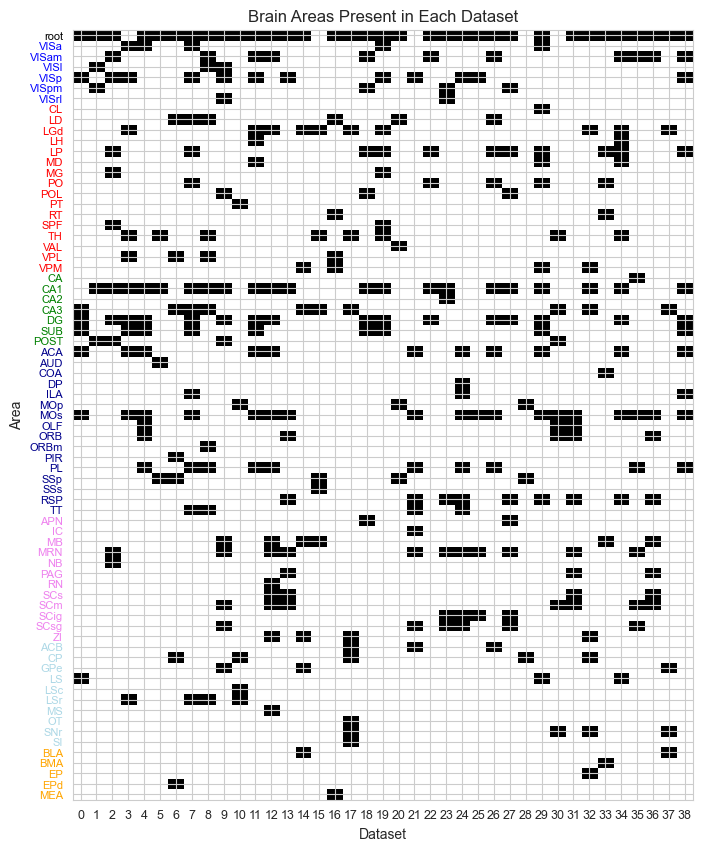

In [3]:
# Function to plot brain areas present in each dataset
def plot_brain_areas(data):
    # Brain Region Information
    regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
    region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
    brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                    ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"],  # thalamus
                    ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                    ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"],  # non-visual cortex
                    ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                    ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                    ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                    ]

    # Assign Each Area an Index
    area_to_index = dict(root=0)
    counter = 1
    for group in brain_groups:
        for area in group:
            area_to_index[area] = counter
            counter += 1

    # Determine Areas in Each Dataset
    areas_by_dataset = np.zeros((counter, len(data)), dtype=bool)
    for j, d in enumerate(data):
        for area in np.unique(d['brain_area']):
            i = area_to_index.get(area, -1)
            if i != -1:
                areas_by_dataset[i, j] = True

    # Visualize the Presence of Neurons in Different Regions Across Datasets
    plt.figure(figsize=(8, 10))
    plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

    # Label the Axes
    plt.xlabel("Dataset")
    plt.ylabel("Area")

    # Add Tick Labels
    yticklabels = ["root"]
    for group in brain_groups:
        yticklabels.extend(group)
    plt.yticks(np.arange(counter), yticklabels, fontsize=8)
    plt.xticks(np.arange(len(data)), fontsize=9)

    # Color the Tick Labels by Region
    ytickobjs = plt.gca().get_yticklabels()
    ytickobjs[0].set_color("black")
    counter = 1
    for group, color in zip(brain_groups, region_colors):
        for area in group:
            ytickobjs[counter].set_color(color)
            counter += 1

    plt.title("Brain Areas Present in Each Dataset")
    plt.grid(True)
    plt.show()

# Plot brain areas present in each dataset
alldat = load_data(filenames)
plot_brain_areas(alldat)

In [4]:
alldat = load_data(filenames)

In [5]:
print(alldat[1].keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [6]:
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"],  # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

In [7]:
brain_areas = []
for region in brain_groups:
    brain_areas += region
print(brain_areas)

['VISa', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl', 'CL', 'LD', 'LGd', 'LH', 'LP', 'MD', 'MG', 'PO', 'POL', 'PT', 'RT', 'SPF', 'TH', 'VAL', 'VPL', 'VPM', 'CA', 'CA1', 'CA2', 'CA3', 'DG', 'SUB', 'POST', 'ACA', 'AUD', 'COA', 'DP', 'ILA', 'MOp', 'MOs', 'OLF', 'ORB', 'ORBm', 'PIR', 'PL', 'SSp', 'SSs', 'RSP', 'TT', 'APN', 'IC', 'MB', 'MRN', 'NB', 'PAG', 'RN', 'SCs', 'SCm', 'SCig', 'SCsg', 'ZI', 'ACB', 'CP', 'GPe', 'LS', 'LSc', 'LSr', 'MS', 'OT', 'SNr', 'SI', 'BLA', 'BMA', 'EP', 'EPd', 'MEA']


In [9]:
def plot_neuron_spikes(spike_data, ax):

                    
    num_neurons = len(spike_data)

    neurons_round = rounded = int(np.ceil(num_neurons / 1000) * 1000)
    
    # Plot spikes using eventplot
    ax.eventplot(spike_data, lineoffsets=range(num_neurons),
                 linelengths=1, colors='black',linestyles='solid')
    
    # Set y-axis ticks and labels
    ax.set_yticks([0, neurons_round//2, neurons_round])
    # ax.set_yticklabels(['1', f'{num_neurons//2}', f'{num_neurons}'])
    ax.set_xticks(np.arange(-500, 2000, 500))
    # ax.set_yticklabels(['-500','0','500','1000','1500','2000'])
    # Set labels and title
    ax.set_ylabel('Neuron')

In [10]:
neuron_dict={}
for area in brain_areas:
    spike_timestamps = []
    spike_array = []
    gocues = np.empty((0,1))
    licks = np.empty((0,250))

In [32]:
for dat in alldat[:1]:
    for key, values in dat.items():
        try:
            ic(type(values))
            ic(f'{key}:{values.shape}')
        except:
            ic(type(values))
            ic(f'{key}:{values}')
        ic('-'*50)

ic| type(values): <class 'numpy.ndarray'>
ic| f'{key}:{values.shape}': 'spks:(734, 214, 250)'
ic| '-'*50: '--------------------------------------------------'
ic| type(values): <class 'numpy.ndarray'>
ic| f'{key}:{values.shape}': 'wheel:(1, 214, 250)'
ic| '-'*50: '--------------------------------------------------'
ic| type(values): <class 'numpy.ndarray'>
ic| f'{key}:{values.shape}': 'pupil:(3, 214, 250)'
ic| '-'*50: '--------------------------------------------------'
ic| type(values): <class 'numpy.ndarray'>
ic| f'{key}:{values.shape}': 'response:(214,)'
ic| '-'*50: '--------------------------------------------------'
ic| type(values): <class 'numpy.ndarray'>
ic| f'{key}:{values.shape}': 'response_time:(214, 1)'
ic| '-'*50: '--------------------------------------------------'
ic| type(values): <class 'float'>
ic| type(values): <class 'float'>
ic| f'{key}:{values}': 'bin_size:0.01'
ic| '-'*50: '--------------------------------------------------'
ic| type(values): <class 'float'>
ic| 

In [13]:
desired_keys = ['spks','response','response_time','contrast_left','contrast_right','brain_area','feedback_time','feedback_type','gocue','prev_reward','ccf','ccf_axes','licks']
neuron_keys = ['brain_area','ccf']
trial_keys = ['response','response_time','contrast_left','contrast_right','feedback_time','feedback_type','gocue']


In [84]:
def trial_subroutines(key, value):
    match key:
        case 'response':
            return value
        case 'response_time':
            return np.squeeze(value)
        case 'contrast_left':
            return value
        case 'contrast_right':
            return value
        case 'feedback_time':
            return np.squeeze(value)
        case 'feedback_type':
            return value
        case 'gocue':
            return np.squeeze(value)
        case _:
            return None

In [91]:
def neuron_subroutines(key, value):
    match key:
        case 'brain_area':
            return value
        # case 'ccf':
        #     return value
        case _:
            return None
        

In [255]:
def dat_subroutines(dat):
    neuron_data = {}
    trial_data = {}
    for key, value in dat.items():
        neuron_result = neuron_subroutines(key, value)
        trial_result = trial_subroutines(key, value)
        
        
        # Only add to dictionary if the result is not 
        if neuron_result is not None:
            neuron_data[key] = neuron_result
        if trial_result is not None:
            trial_data[key] = trial_result
            

    # Create DataFrames from the processed data
    neuron_df = pd.DataFrame(neuron_data)
    trial_df = pd.DataFrame(trial_data)

    # Add common fields
    for df in [neuron_df, trial_df]:
        if 'mouse_name' in dat:
            df['mouse_name'] = dat['mouse_name']
        if 'date_exp' in dat:
            df['date_exp'] = pd.to_datetime(dat['date_exp'])
    
    neuron_df[[*dat['ccf_axes']]] = dat['ccf']
    
    # Add index columns
    neuron_df['neuron_id'] = range(len(neuron_df))
    trial_df['trial_id'] = range(len(trial_df))

    # Create cross join between neurons and trials
    # First, add a temporary key for merging
    neuron_df['_merge_key'] = 1
    trial_df['_merge_key'] = 1
    
    # Perform the merge
    merged_df = pd.merge(
        neuron_df,
        trial_df,
        on='_merge_key',
        suffixes=('_neuron', '_trial')
    ).drop('_merge_key', axis=1)
    
    # Deduplicate common columns (mouse_name and date_exp)
    for col in merged_df.columns:
        if col.endswith('_neuron') and col.replace('_neuron', '_trial') in merged_df.columns:
            base_col = col.replace('_neuron', '')
            if (merged_df[col] == merged_df[col.replace('_neuron', '_trial')]).all():
                merged_df[base_col] = merged_df[col]
                merged_df = merged_df.drop([col, col.replace('_neuron', '_trial')], axis=1)
    
    # Reset the index
    merged_df = merged_df.reset_index(drop=True)
    spikes = dat['spks'].reshape(-1,250)
    merged_df['spks'] = list(spikes)
    
    return merged_df


In [256]:
concat_df = pd.DataFrame()
for dat in alldat:
    dfs = []
    dfs.append(dat_subroutines(dat))
    concat_df = pd.concat(dfs)


In [258]:
concat_df.head(50)

,brain_area,ap,dv,lr,neuron_id,response,response_time,contrast_right,contrast_left,feedback_time,feedback_type,gocue,trial_id,mouse_name,date_exp,spks
0,SUB,8667.2,1969.6,3549.2,0,1.0,0.903312,0.00,1.00,0.946524,1.0,0.508117,0,Theiler,2017-10-11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,SUB,8667.2,1969.6,3549.2,0,1.0,0.859908,1.00,0.00,0.859908,-1.0,0.678304,1,Theiler,2017-10-11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."
2,SUB,8667.2,1969.6,3549.2,0,-1.0,0.646241,1.00,0.00,0.683098,1.0,0.508295,2,Theiler,2017-10-11,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,SUB,8667.2,1969.6,3549.2,0,-1.0,0.985264,0.25,0.00,1.022429,1.0,0.437219,3,Theiler,2017-10-11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,SUB,8667.2,1969.6,3549.2,0,1.0,1.137715,0.25,1.00,1.175197,1.0,0.672789,4,Theiler,2017-10-11,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
5,SUB,8667.2,1969.6,3549.2,0,-1.0,1.347198,0.00,0.00,1.347198,-1.0,0.792496,5,Theiler,2017-10-11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,SUB,8667.2,1969.6,3549.2,0,-1.0,1.547357,0.00,0.00,1.547357,-1.0,0.418041,6,Theiler,2017-10-11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,SUB,8667.2,1969.6,3549.2,0,0.0,2.211240,0.00,0.00,2.244473,1.0,0.708446,7,Theiler,2017-10-11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,SUB,8667.2,1969.6,3549.2,0,-1.0,0.699030,0.25,0.00,0.736231,1.0,0.558628,8,Theiler,2017-10-11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,SUB,8667.2,1969.6,3549.2,0,-1.0,1.131284,0.50,0.25,1.167745,1.0,0.758138,9,Theiler,2017-10-11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
